In [16]:
## LIBRARIES

import pandas as pd
import pickle
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix
import math
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import bentoml
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle
from matplotlib import *
import sys
from sklearn.multiclass import OneVsOneClassifier
from sklearn.preprocessing import label_binarize
from sklearn.datasets import make_classification
from sklearn.svm import SVC
from pylab import *
from sklearn.metrics import roc_auc_score
from sklearn.naive_bayes import GaussianNB
import pylab as pl
from matplotlib import figure
from matplotlib import pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
import numpy as np
from scipy.stats import boxcox 
import pyreadr 
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import scale 
import seaborn as sns 
import matplotlib as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import plotly.express as px
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.datasets import fetch_california_housing
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb


Undestanding the Data

The dataset provided in this notebook is part of a personal project of mine to try and get insights from Messi's career penalties that I find useful in designing a model that accurately predicts his aim at goal during penalties. Penalty Shootouts were left out now but will be included in future modifications of this project. 

The aim of this notebook is to design a model that predicts the variable 'aim' of such characteristics of the kick as:

1. 'team' - This is the team he took the kick for.

2. 'opposition' - This is the team he took the kick against.

3. 'minute-taken' - This is the minute of the kick.

4. 'scoreline' - The scoreline before the kick was taken; 'lead' meaning his team was in the lead before the kick, 'draw' meaning his team were drawing, and 'losing' meaning his team were behind in the match beforethe spotkick.

5. 'venue' - The grounds which the kick was taken on. 'home' means his current team homeground, 'away' meaning not his current team homeground, 'neutral' being on a neutral ground.

6. 'previous_penalty' - The outcome of the last kick taken by Messi; 1 if scored, 0 if missed, 'N/A' if entry is first career kick.

7. 'natural_foot' - Player most dominant foot.

8. 'position_style' - To which direction behind the ball he stood before taking the kick.

9. 'competition' - The competition which the kick was taken in.

10. 'gk' - The opposition goal keeper.

In [17]:
## Data frame

df = pd.read_excel('Messi_Penalties.xlsx')

In [18]:
## Dataframe details

df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137 entries, 0 to 136
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   team for      137 non-null    object
 1   team against  137 non-null    object
 2   time          137 non-null    int64 
 3   scoreline     137 non-null    object
 4   venue         137 non-null    object
 5   history       137 non-null    int64 
 6   natural foot  137 non-null    object
 7   position      137 non-null    object
 8   competition   137 non-null    object
 9   GK            137 non-null    object
 10  direction     137 non-null    object
dtypes: int64(2), object(9)
memory usage: 11.9+ KB


In [19]:
## Clean data 

def clean (data1):
    data1= data1.applymap(lambda s:s.lower().replace(' ', '_') if type(s) == str else s)
    data1.columns = [x.lower().replace(' ', '_') for x in data1.columns]
    data1.columns = [x.lower().replace(':', '') for x in data1.columns]
    data1.columns = [x.lower().replace('*', '') for x in data1.columns]
    data1.columns = [x.lower().replace('.', '') for x in data1.columns] 
    data1.competition = [x.lower().replace('_', '') for x in data1.competition]
    return data1

df1 = clean(df)

In [20]:
## Check competition variable

df1.competition.value_counts()

laliga         76
ucl            21
friendly       12
copadelrey      8
qualifiers      7
wc              6
supercup        4
copaamerica     3
Name: competition, dtype: int64

In [21]:
## Data frame info 
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137 entries, 0 to 136
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   team_for      137 non-null    object
 1   team_against  137 non-null    object
 2   time          137 non-null    int64 
 3   scoreline     137 non-null    object
 4   venue         137 non-null    object
 5   history       137 non-null    int64 
 6   natural_foot  137 non-null    object
 7   position      137 non-null    object
 8   competition   137 non-null    object
 9   gk            137 non-null    object
 10  direction     137 non-null    object
dtypes: int64(2), object(9)
memory usage: 11.9+ KB


In [22]:
## Check null variables

nulls = df1.isnull().sum(axis = 0)
nulls

team_for        0
team_against    0
time            0
scoreline       0
venue           0
history         0
natural_foot    0
position        0
competition     0
gk              0
direction       0
dtype: int64

In [23]:
## Check duplicate data

duplicate = df1.duplicated().sum()
print('There are {} duplicated rows in the data'.format(duplicate))

There are 0 duplicated rows in the data


In [46]:
## Statistics of the data

df.describe(include=np.number)

,time,history
count,137.000000,137.000000
mean,54.014599,0.788321
std,24.586876,0.409997
min,5.000000,0.000000
25%,34.000000,1.000000
50%,55.000000,1.000000
75%,76.000000,1.000000
max,90.000000,1.000000


In [47]:
## Data description
df1.describe(include = object)

,team_for,team_against,scoreline,venue,natural_foot,position,competition,gk,direction
count,137,137,137,137,137,137,137,137,137
unique,3,64,3,3,1,1,8,89,3
top,barcelona,valencia,draw,home,left,right,laliga,alves,right
freq,106,9,64,81,137,137,77,5,69


In [11]:
## Correlacion 
matrix = df1.corr()
matrix.style.background_gradient(cmap='coolwarm')

/var/folders/zw/mb45ddnn0g98d2p147gt67bm0000gn/T/ipykernel_49778/2518453628.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  matrix = df1.corr()


,time,history
time,1.000000,0.156404
history,0.156404,1.000000


In [49]:
df1.columns

Index(['team_for', 'team_against', 'time', 'scoreline', 'venue', 'history',
       'natural_foot', 'position', 'competition', 'gk', 'direction'],
      dtype='object')

In [24]:
## Take out columns

def drop(data):
    
    return data.drop(columns=['natural_foot','position','team_against','gk'])

df2 = drop(df1)
df2

,team_for,time,scoreline,venue,history,competition,direction
0,argentina,40,draw,neutral,0,wc,left
1,argentina,75,draw,neutral,1,wc,right
2,argentina,55,losing,neutral,1,friendly,left
3,barcelona,79,lead,home,1,laliga,right
4,barcelona,80,lead,home,1,laliga,middle
...,...,...,...,...,...,...,...
132,argentina,8,draw,neutral,0,friendly,right
133,argentina,45,lead,neutral,1,friendly,right
134,argentina,10,draw,neutral,1,wc,left
135,argentina,39,draw,neutral,1,wc,right


In [25]:
# Check frequency

for var in df2: 
    
    print(df2[var].value_counts()/np.float(len(df2)))

barcelona    0.773723
argentina    0.204380
psg          0.021898
Name: team_for, dtype: float64
90    0.065693
55    0.043796
86    0.036496
57    0.036496
82    0.029197
        ...   
88    0.007299
56    0.007299
9     0.007299
63    0.007299
10    0.007299
Name: time, Length: 69, dtype: float64
draw      0.467153
lead      0.430657
losing    0.102190
Name: scoreline, dtype: float64
home       0.591241
away       0.299270
neutral    0.109489
Name: venue, dtype: float64
1    0.788321
0    0.211679
Name: history, dtype: float64
laliga         0.554745
ucl            0.153285
friendly       0.087591
copadelrey     0.058394
qualifiers     0.051095
wc             0.043796
supercup       0.029197
copaamerica    0.021898
Name: competition, dtype: float64
right     0.503650
left      0.379562
middle    0.116788
Name: direction, dtype: float64


/var/folders/zw/mb45ddnn0g98d2p147gt67bm0000gn/T/ipykernel_49778/3210155241.py:5: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

/var/folders/zw/mb45ddnn0g98d2p147gt67bm0000gn/T/ipykernel_49778/3210155241.py:5: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

/var/folders/zw/mb45ddnn0g98d2p147gt67bm0000gn/T/ipykernel_49778/3210155241.py:5: De

Plots

In [26]:
sns.set_style('darkgrid')
plt.rcParams['font.size'] = 14
plt.rcParams['figure.figsize'] = (10,6)
plt.rcParams['figure.facecolor'] = '#00000000'

In [33]:
## Penalties per team and competition
px.histogram(df2, x='competition', title='All Competition Kicks By Team', color='team_for',color_discrete_map = {'argentina':'violet','barcelona':'black','psg':'yellow'})

<AxesSubplot: title={'center': 'Aim at Goal'}>

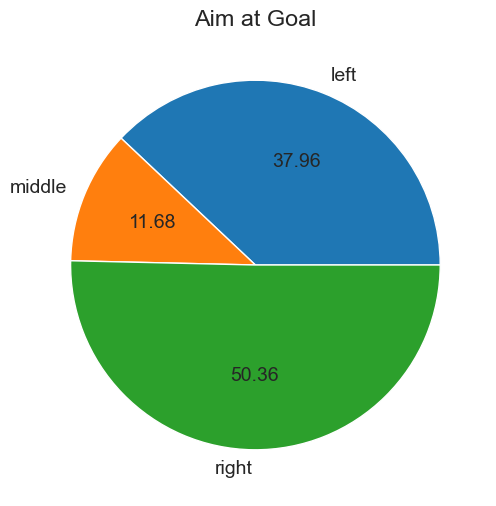

In [28]:
## Group by position
df2.groupby('direction').size().plot(kind='pie', autopct='%.2f', title='Aim at Goal',ylabel='')

<AxesSubplot: title={'center': 'All Competition Kicks'}, xlabel='competition', ylabel='Number of Kicks'>

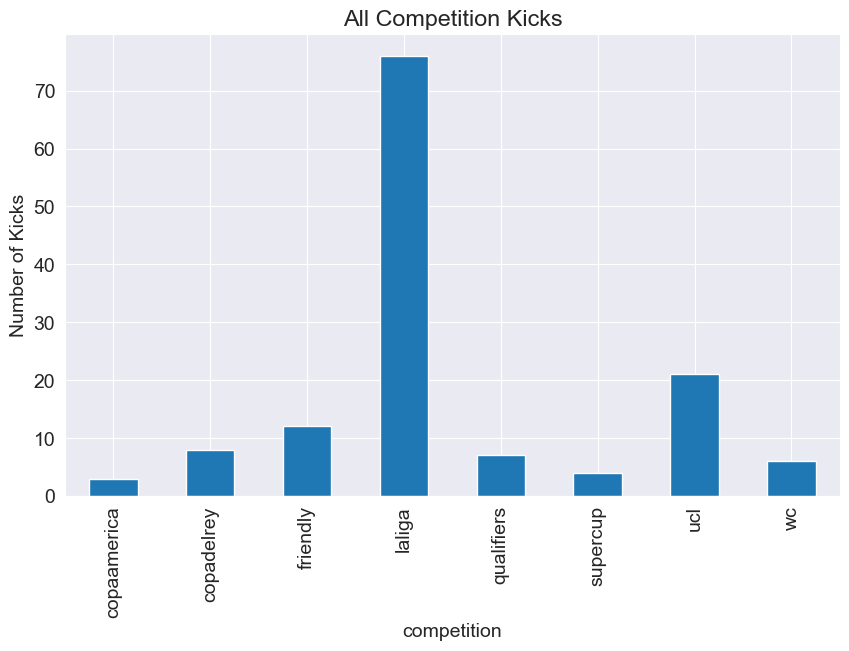

In [32]:
## Groupby competition
df2.groupby('competition').size().plot(kind='bar',xlabel='competition', ylabel='Number of Kicks', title='All Competition Kicks')

<AxesSubplot: title={'center': 'Kick Accuracy'}>

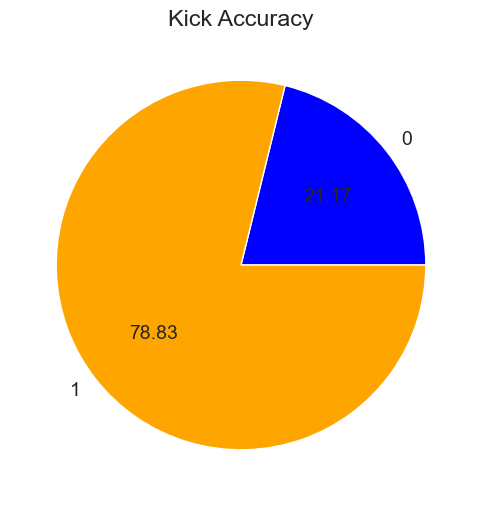

In [31]:
## Group by previous penaly (history)

df2.groupby('history').size().plot(kind='pie', autopct='%.2f', title='Kick Accuracy',ylabel='',colors = ['blue', 'orange'])

<AxesSubplot: >

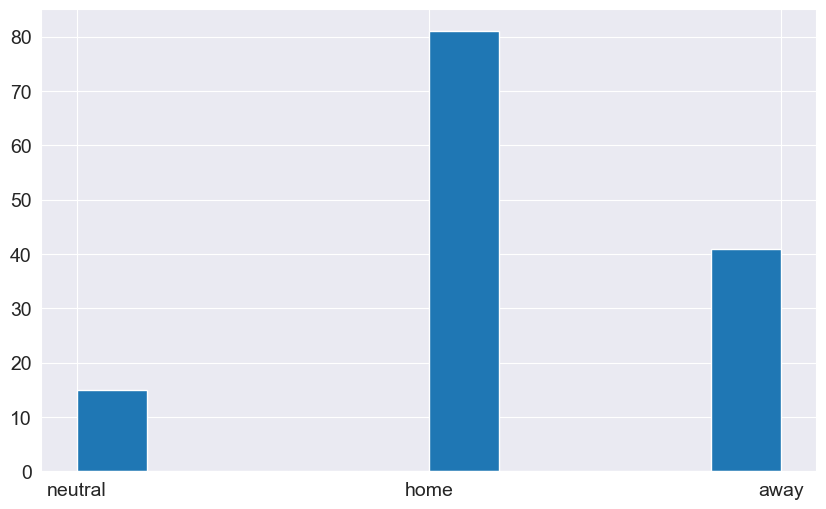

In [34]:
## Check venue
df2.venue.hist()

<AxesSubplot: title={'center': 'Kicks by Team'}>

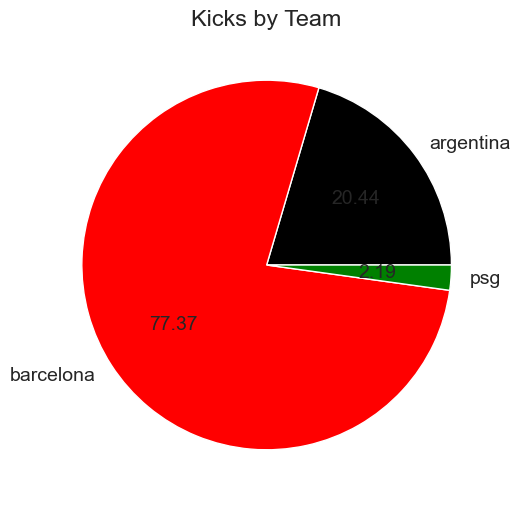

In [35]:
## Group by team

df2.groupby('team_for').size().plot(kind='pie', autopct='%.2f',ylabel='',title='Kicks by Team',colors=['black','red','green','yellow'])

In [36]:
df2.columns

Index(['team_for', 'time', 'scoreline', 'venue', 'history', 'competition',
       'direction'],
      dtype='object')

In [37]:
##Create a dataframe with the predictor variables

## Transformar data
df2['direction']=df['direction'].map({'left':0, 'right':1,'middle':2})
categorical = ['team_for', 'time', 'scoreline', 'venue', 'history', 'competition']

In [38]:
df2

,team_for,time,scoreline,venue,history,competition,direction
0,argentina,40,draw,neutral,0,wc,0
1,argentina,75,draw,neutral,1,wc,1
2,argentina,55,losing,neutral,1,friendly,0
3,barcelona,79,lead,home,1,laliga,1
4,barcelona,80,lead,home,1,laliga,2
...,...,...,...,...,...,...,...
132,argentina,8,draw,neutral,0,friendly,1
133,argentina,45,lead,neutral,1,friendly,1
134,argentina,10,draw,neutral,1,wc,0
135,argentina,39,draw,neutral,1,wc,1


In [39]:
## Split data set 

df_train, df_test =train_test_split(df2, test_size=0.20,random_state=123)

y = df2.direction

## Extracr Y variable
y_train = (df_train.direction).values
y_test = (df_test.direction).values

del df_train['direction']
del df_test['direction']

## To dictionary
dict_train = df_train.to_dict(orient='records')
dict_test = df_test.to_dict(orient='records')

## Vectorize

dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(dict_train)
X_test = dv.transform(dict_test)



In [40]:
## One vs Restt

# define model
model = SVC(decision_function_shape='ovo')


# Fit el modelo
model.fit(X_train, y_train)

## ACCURACY

## Train data set
y_pred_train = model.predict(X_train)
print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_pred_train)))


## Test data set
y_pred = model.predict(X_test)
print('Test Model accuracy score: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

## Predictions
print(y_pred[0:10])

## Confusion matrix
cm = confusion_matrix(y_test,y_pred)
print(cm)

accuracy_score(y_test,y_pred)*100


Training-set accuracy score: 0.5596
Test Model accuracy score: 0.3571
[1 1 1 1 1 1 1 1 1 1]
[[ 1 10  0]
 [ 2  9  0]
 [ 0  6  0]]


35.714285714285715

In [41]:
## Decision Tree

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score

## Model
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

## ACCURACY

## Train data set
y_pred_train = dt.predict(X_train)
print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_pred_train)))


## Test data set
y_pred = dt.predict(X_test)
print('Test Model accuracy score: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

## Predictions
print(y_pred[0:10])

## Confusion matrix
cm = confusion_matrix(y_test,y_pred)
print(cm)

accuracy_score(y_test,y_pred)*100

Training-set accuracy score: 0.9725
Test Model accuracy score: 0.3929
[1 1 0 1 1 1 1 1 1 1]
[[4 6 1]
 [4 6 1]
 [1 4 1]]


39.285714285714285

In [42]:
## Naive Bayes

# Definir el modelo
gnb = GaussianNB()


# Fit el modelo
gnb.fit(X_train, y_train)

## ACCURACY

## Train data set
y_pred_train = gnb.predict(X_train)
print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_pred_train)))


## Test data set
y_pred = gnb.predict(X_test)
print('Test Model accuracy score: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

## Predictions
print(y_pred[0:10])

## Confusion matrix
cm = confusion_matrix(y_test,y_pred)
print(cm)

accuracy_score(y_test,y_pred)*100


Training-set accuracy score: 0.2569
Test Model accuracy score: 0.4643
[1 2 2 2 2 2 1 0 2 0]
[[5 0 6]
 [1 2 8]
 [0 0 6]]


46.42857142857143

In [52]:
## XGboost Model 


def hyperParameterTuning(X_train, y_train):
    xgb_params = {
        'learning_rate': [0.001, 0.1, 0.5,1],
        'max_depth': [3, 7, 9, 15],
        'min_child_weight': [1, 1.5, 3],
        'subsample': [0.5, 0.7],
        'num_class':[3],
        'colsample_bytree': [0.5, 0.7],
        'n_estimators' : [100, 200, 500],
        'objective': ['multi:softmax']
    }

    model = XGBClassifier()

    gsearch = GridSearchCV(estimator = model,
                           param_grid = xgb_params,                        
                           #scoring = 'neg_mean_absolute_error', #MAE
                           #scoring = 'neg_mean_squared_error',  #MSE
                           cv = 5,
                           n_jobs = -1,
                           verbose = 1)

    gsearch.fit(X_train,y_train)

    return gsearch.best_params_



In [53]:
hyperParameterTuning(X_train, y_train)

Fitting 5 folds for each of 576 candidates, totalling 2880 fits


{'colsample_bytree': 0.5,
 'learning_rate': 0.1,
 'max_depth': 9,
 'min_child_weight': 1,
 'n_estimators': 100,
 'num_class': 3,
 'objective': 'multi:softmax',
 'subsample': 0.5}

BEST MODEL

In [54]:
model = XGBClassifier(
colsample_bytree = 0.5,
learning_rate = 0.1,
max_depth = 9,
min_child_weight = 1,
n_estimators = 100,
num_class = 3,
objective = 'multi:softmax',
subsample = 0.5)

%time model.fit(X_train, y_train, early_stopping_rounds=5, eval_set=[(X_train, y_train)], verbose=False)

y_pred = model.predict(X_train)
from sklearn.metrics import accuracy_score
score = accuracy_score(y_train, y_pred)
print("Accuracy: %f" % (score))
#mae_xgb = mean_absolute_error(y_val, y_pred_xgb)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



CPU times: user 647 ms, sys: 627 ms, total: 1.27 s
Wall time: 334 ms
Accuracy: 0.853211


In [55]:
import bentoml
bentoml.xgboost.save_model("messi_model",model, custom_objects={"DictVectorizer":dv},
signatures={"predict": {"batchable":True,"batch_dim":0,}})

Model(tag="messi_model:jwj2jwt27gv5ppve", path="/Users/alexandervalverde/bentoml/models/messi_model/jwj2jwt27gv5ppve/")